In [1]:
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patches
from numpy import interp
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, LeaveOneGroupOut
from sklearn.model_selection import LeaveOneOut
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import recall_score, plot_roc_curve
from sklearn.metrics import confusion_matrix, roc_curve, auc

Посмотрим на данные


In [2]:
data = pd.read_excel('medicina3.xlsx')
data.head(5)

,gr,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28
0,1,39,0,5,11,2,1,0,1,1,...,1.30,1.47,18.2,122.0,1,3,1,3,0,9
1,1,36,0,3,6,2,1,1,1,1,...,0.89,1.09,45.6,108.0,1,3,0,3,0,9
2,1,28,0,5,10,2,1,0,1,1,...,0.56,0.77,60.1,67.0,1,3,0,3,0,9
3,1,28,1,5,11,2,1,1,1,1,...,0.51,0.62,38.1,108.0,0,1,0,3,0,9
4,1,40,1,5,12,2,1,1,1,1,...,0.34,0.42,8.0,99.0,1,3,0,3,0,9


In [3]:
for col_name in data.columns:
    print(col_name, len(data[col_name].unique()))

gr 2
v1 35
v2 2
v3 7
v4 18
v5 3
v6 2
v7 2
v8 3
v9 2
v10 2
v11 2
v12 211
v13 207
v14 73
v15 58
v16 91
v17 106
v18 126
v19 96
v20 113
v21 123
v22 138
v23 4
v24 4
v25 5
v26 5
v27 4
v28 7


Как видно прогнозируемая переменная gr состоит из 2 исходов, следовательно у нас
задача бинарной классификации.

In [4]:
data.isna().sum()

gr     0
v1     0
v2     0
v3     0
v4     0
v5     0
v6     0
v7     0
v8     0
v9     0
v10    0
v11    0
v12    0
v13    0
v14    0
v15    0
v16    0
v17    0
v18    0
v19    0
v20    0
v21    0
v22    0
v23    0
v24    0
v25    0
v26    0
v27    0
v28    0
dtype: int64

Пропусков нет, поэтому разбиваем модели на train и test.

Для удобства заменим группу 1 на 0 и группу 2 на 1

In [3]:
data['gr'] -= 1
data.head()

,gr,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28
0,0,39,0,5,11,2,1,0,1,1,...,1.30,1.47,18.2,122.0,1,3,1,3,0,9
1,0,36,0,3,6,2,1,1,1,1,...,0.89,1.09,45.6,108.0,1,3,0,3,0,9
2,0,28,0,5,10,2,1,0,1,1,...,0.56,0.77,60.1,67.0,1,3,0,3,0,9
3,0,28,1,5,11,2,1,1,1,1,...,0.51,0.62,38.1,108.0,0,1,0,3,0,9
4,0,40,1,5,12,2,1,1,1,1,...,0.34,0.42,8.0,99.0,1,3,0,3,0,9


In [4]:

X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['gr']), data[['gr']],
                                                    test_size=0.3, random_state=241)

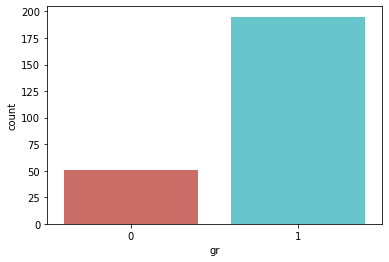

In [7]:
sns.countplot(x='gr', data=data, palette='hls')
plt.savefig('gr.jpg')
plt.show()

In [8]:
count_no_sub = len(data[data['gr']==0])
pct_of_no_sub = count_no_sub/len(data['gr'])
print("процент первого исхода", pct_of_no_sub*100)

процент первого исхода 20.73170731707317


In [9]:
data.groupby('gr').mean()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28
gr,,,,,,,,,,,,,,,,,,,,,
0,36.137255,0.450980,3.509804,8.588235,1.784314,0.882353,0.607843,0.882353,0.980392,0.607843,...,1.771373,1.949020,17.958824,105.425490,0.705882,1.450980,0.137255,1.784314,0.372549,8.607843
1,37.194872,0.492308,-3.261538,9.456410,1.379487,0.415385,0.082051,0.384615,0.707692,0.435897,...,1.151128,1.195846,12.793487,95.793846,0.323077,1.076923,0.066667,0.251282,0.276923,5.651282


Уже на этой стадии можно заметить большую разницу в некоторых признаках, например
v3 - разные знаки
v7 для признака 1 больше в 7 раз
и т.д.

Для логистической регрессии используем только значимые переменные. Будем использовать
RFE(Рекурсивное устранение признаков).

In [97]:


data_vars=data.columns.values.tolist()
y=['gr']
X=[i for i in data_vars if i not in y]

logreg = LogisticRegression()
rfe = RFE(logreg)
rfe = rfe.fit(X_train, y_train.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

d:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
d:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver o

[False False  True False  True  True  True  True  True False  True False
 False False False False False False  True  True False False  True  True
  True  True False]
[10  2  1  4  1  1  1  1  1  3  1 15 14  9  7  6  5 11  1  1 12 13  1  1
  1  1  8]


In [98]:
X_rfe = X_train.iloc[:,rfe.support_]
X_rfe

,v3,v5,v6,v7,v8,v9,v11,v19,v20,v23,v24,v25,v26
44,1,1,1,0,0,1,0,0.56,0.72,0,1,0,1
14,1,2,1,1,1,1,1,0.77,1.03,1,1,1,3
37,5,2,1,1,2,1,1,8.20,7.05,0,1,0,0
95,2,1,0,0,0,0,0,0.16,0.17,0,1,0,0
204,2,1,0,0,1,1,1,0.18,0.19,2,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,0,1,0,0,0,1,1,0.25,0.28,0,2,0,0
235,1,2,0,0,0,1,1,0.24,0.28,0,1,0,0
90,1,1,1,0,0,1,1,14.70,15.30,0,2,0,0
30,3,2,1,1,1,1,1,1.44,1.90,0,1,0,2


In [99]:
y_rfe = y_train['gr']
y_rfe

44     0
14     0
37     0
95     1
204    1
      ..
144    1
235    1
90     1
30     0
172    1
Name: gr, Length: 172, dtype: int64

Посмотрим на статистику модели.

In [100]:
import statsmodels.api as sm
logit_model = sm.Logit(y_rfe,X_rfe)
result = logit_model.fit()
print(result.summary2())


Optimization terminated successfully.
         Current function value: 0.299391
         Iterations 9
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.407     
Dependent Variable: gr               AIC:              128.9906  
Date:               2020-11-06 21:56 BIC:              169.9080  
No. Observations:   172              Log-Likelihood:   -51.495   
Df Model:           12               LL-Null:          -86.894   
Df Residuals:       159              LLR p-value:      2.2702e-10
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     9.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
v3        -0.0037     0.0174   -0.2105   0.8333   -0.0377    0.0304
v5         1.4998     0.4650    3.2251   0.0013    0.5884 

Удалим параметры с высоким P>|z|

In [101]:
X_drop = X_rfe.drop(['v6','v3','v8','v9','v24'], axis=1)

In [102]:
import statsmodels.api as sm
logit_model = sm.Logit(y_rfe, X_drop)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.303600
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.399     
Dependent Variable: gr               AIC:              120.4384  
Date:               2020-11-06 21:56 BIC:              145.6183  
No. Observations:   172              Log-Likelihood:   -52.219   
Df Model:           7                LL-Null:          -86.894   
Df Residuals:       164              LLR p-value:      1.9985e-12
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     8.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
v5         1.5823     0.3165    4.9996   0.0000    0.9620    2.2026
v7        -2.9369     0.7048   -4.1672   0.0000   -4.3182 

In [5]:
#X_train_ = X_drop
#y_train = y_rfe
#X_test = X_test[X_train_.columns]

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

d:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
d:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


<b>Accuracy</b> for logreg

In [6]:
print('Accuracy :'
      ' {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy : 0.86


Матрица ошибок

In [7]:

confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[10  6]
 [ 4 54]]


In [106]:
sen = confusion_matrix[1,1] / (confusion_matrix[1,1] + confusion_matrix[1,0])
print('Sensitivity :', sen)

Sensitivity : 0.9482758620689655


In [107]:
spec = confusion_matrix[0,0]/(confusion_matrix[0,0] + confusion_matrix[0,1])
print('Specificity :', spec)

Specificity : 0.75


In [108]:
precision = confusion_matrix[1,1]/ (confusion_matrix[1,1] + confusion_matrix[0,1])
print('F-мера :', 2*sen*precision/(sen + precision))


F-мера : 0.94017094017094


ROC-AUC in cross validation


In [148]:
import sklearn.metrics as metrics

def roc_auc(classifier, X, y,name_gr, name='default'):
    cv = StratifiedKFold(n_splits=5,random_state =5)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X.iloc[train], y.iloc[train])
        viz = plot_roc_curve(classifier, X.iloc[test], y.iloc[test],
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)

        #fpr, tpr, threshold = metrics.roc_curve(y.iloc[test], classifier.predict_proba(X.iloc[test])[:,1])
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f )' % mean_auc,
            lw=2, alpha=.8)

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    ax.set_title("ROC-AUC for " + name_gr, fontsize = 15)
    ax.set_xlabel('True Positive Rate', fontsize = 12)
    ax.set_ylabel('False Positive Rate', fontsize = 12)
    ax.legend(loc="lower right")
    plt.savefig(name, format='pdf')
    plt.show()


d:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


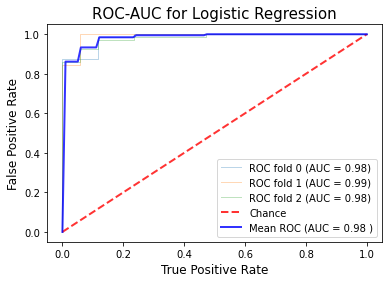

In [37]:
X = data[X_test.columns]
y = data['gr']
roc_auc(logreg, X, y,'Logistic Regression','logreg.pdf')


Достаточно неплохие результаты, однако хотелось бы повысить Specificity
Попробуем метод опорных векторов.

In [11]:
svm_ = svm.SVC()
svm_.fit(X_train, y_train)
y_pred = svm_.predict(X_test)

d:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [12]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
confusion_matrix1 = confusion_matrix(y_test, y_pred)
print(confusion_matrix1)

[[ 1 15]
 [ 5 53]]


In [13]:
print('Accuracy :'
      ' {:.2f}'.format(svm_.score(X_test, y_test)))

Accuracy : 0.73


In [41]:
sen = confusion_matrix1[1,1] / (confusion_matrix1[1,1] + confusion_matrix1[1,0])
print('Sensitivity :', sen)

Sensitivity : 0.9482758620689655


In [42]:
spec = confusion_matrix1[0,0]/(confusion_matrix1[0,0] + confusion_matrix1[0,1])
print('Specificity :', spec)

Specificity : 0.875


In [43]:
precision = confusion_matrix1[1,1]/ (confusion_matrix1[1,1] + confusion_matrix1[0,1])
print('F-мера :', 2*sen*precision/(sen + precision))

F-мера : 0.9565217391304347


d:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
d:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
d:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


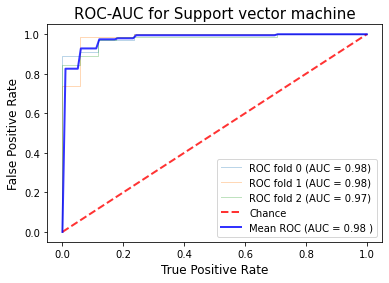

In [44]:
X = data[X_test.columns]
y = data['gr']
roc_auc(svm_, X, y,'Support vector machine', 'svm.pdf')

Random forest

In [139]:
X_train = data.drop(columns=['gr'])[:146]
X_test = data.drop(columns=['gr'])[146:]
y_train = data['gr'][:146]
y_test = data['gr'][146:]

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

In [140]:
from sklearn.metrics import confusion_matrix

confusion_matrix2 = confusion_matrix(y_test, pred_rf)
print(confusion_matrix2)

[[ 0  0]
 [ 5 95]]


In [132]:
print('Accuracy :'
      ' {:.2f}'.format(rf.score(X_test, y_test)))

Accuracy : 0.89


In [90]:
sen = confusion_matrix2[1,1] / (confusion_matrix2[1,1] + confusion_matrix2[1,0])
print('Sensitivity :', sen)

Sensitivity : 0.9655172413793104


In [91]:
spec = confusion_matrix2[0,0]/(confusion_matrix2[0,0] + confusion_matrix2[0,1])
print('Specificity :', spec)

Specificity : 0.6875


In [92]:
precision = confusion_matrix2[1,1]/ (confusion_matrix2[1,1] + confusion_matrix2[0,1])
print('F-мера :', 2*sen*precision/(sen + precision))

F-мера : 0.9411764705882353


d:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
d:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
d:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
d:\program files (x86)\microsof

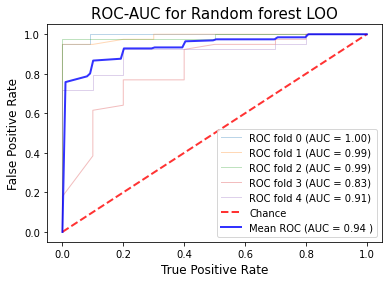

In [149]:
roc_auc(rf, data.drop(columns=['gr', 'v28']), data[['gr']], 'Random forest LOO','random_forest_loo.pdf')

In [120]:
np.mean(cross_val_score(rf,data.drop(columns=['gr']), data[['gr']]))

d:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prog

0.9551836734693877

Adaboost

In [66]:
from sklearn.ensemble import AdaBoostClassifier
adaboost = AdaBoostClassifier(n_estimators=20)
adaboost.fit(X_train, y_train)
ada_pred = adaboost.predict(X_test)

d:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [67]:
confusion_matrix3 = confusion_matrix(y_test, ada_pred)
print(confusion_matrix3)


[[14  2]
 [ 2 56]]


In [68]:
print('Accuracy :'
      ' {:.2f}'.format(adaboost.score(X_test, y_test)))

Accuracy : 0.95


In [69]:
sen = confusion_matrix3[1,1] / (confusion_matrix3[1,1] + confusion_matrix3[1,0])
print('Sensitivity :', sen)

Sensitivity : 0.9655172413793104


In [70]:
spec = confusion_matrix3[0,0]/(confusion_matrix3[0,0] + confusion_matrix3[0,1])
print('Specificity :', spec)

Specificity : 0.875


In [71]:
precision = confusion_matrix3[1,1]/ (confusion_matrix3[1,1] + confusion_matrix3[0,1])
print('F-мера :', 2*sen*precision/(sen + precision))

F-мера : 0.9655172413793104


d:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
d:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
d:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


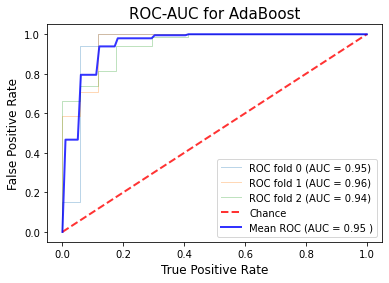

In [72]:
roc_auc(adaboost, data.drop(columns=['gr']), data[['gr']],'AdaBoost' ,'adaboost.pdf')

In [73]:
np.mean(cross_val_score(adaboost,data.drop(columns=['gr']), data[['gr']]))

d:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
d:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
d:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
d:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\sklearn\utils\validation.py:73: DataC

0.9348571428571428

GradientBoosting

In [74]:
from sklearn.ensemble import GradientBoostingClassifier
grad_boost = GradientBoostingClassifier(n_estimators=20)
grad_boost.fit(X_train, y_train)
grad_pred = adaboost.predict(X_test)


d:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [75]:
confusion_matrix4 = confusion_matrix(y_test, grad_pred)
print(confusion_matrix4)

[[14  2]
 [ 1 57]]


In [76]:
print('Accuracy :'
      ' {:.2f}'.format(grad_boost.score(X_test, y_test)))

Accuracy : 0.96


In [77]:
sen = confusion_matrix4[1,1] / (confusion_matrix4[1,1] + confusion_matrix4[1,0])
print('Sensitivity :', sen)

Sensitivity : 0.9827586206896551


In [78]:
spec = confusion_matrix4[0,0]/(confusion_matrix4[0,0] + confusion_matrix4[0,1])
print('Specificity :', spec)

Specificity : 0.875


In [79]:
precision = confusion_matrix4[1,1]/ (confusion_matrix4[1,1] + confusion_matrix4[0,1])
print('F-мера :', 2*sen*precision/(sen + precision))

F-мера : 0.9743589743589743


d:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
d:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
d:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


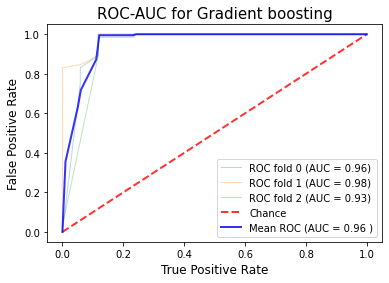

In [80]:
roc_auc(grad_boost, data.drop(columns=['gr']), data[['gr']],'Gradient boosting', 'grad.pdf')

In [81]:
np.mean(cross_val_score(grad_boost,data.drop(columns=['gr']), data[['gr']]))
#%

d:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
d:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
d:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
d:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\sklearn\utils\validation.py:73: DataC

0.9553469387755102

In [141]:
data


,gr,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28
0,0,39,0,5,11,2,1,0,1,1,...,1.30,1.47,18.2,122.0,1,3,1,3,0,9
1,0,36,0,3,6,2,1,1,1,1,...,0.89,1.09,45.6,108.0,1,3,0,3,0,9
2,0,28,0,5,10,2,1,0,1,1,...,0.56,0.77,60.1,67.0,1,3,0,3,0,9
3,0,28,1,5,11,2,1,1,1,1,...,0.51,0.62,38.1,108.0,0,1,0,3,0,9
4,0,40,1,5,12,2,1,1,1,1,...,0.34,0.42,8.0,99.0,1,3,0,3,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,1,31,0,2,8,2,0,0,1,0,...,0.78,0.95,22.4,98.0,0,1,0,0,0,5
242,1,36,0,2,14,1,0,0,0,1,...,0.44,0.58,19.0,132.0,0,1,0,2,0,4
243,1,33,1,1,13,1,0,0,0,1,...,0.56,0.71,24.5,115.0,0,1,0,0,0,5
244,1,35,1,2,10,2,0,0,0,0,...,0.75,0.97,17.5,110.0,0,1,0,0,0,6
